# Introduction
In this project we are going to analyze 'Brain tumor dataset', a T1 weighted MRI dataset from figshare,
<br>
apply preprocessing functions and create image classification model based on Convolutional neural network that predicts brain tumor type.
#### This project inludes:
- Image data analysis
- Preprocessing data
- Image classification model
- Final conclusion and thoughts
<br>

Highly reccomended to read the **data-description.txt** file to understand data organization.

# I Data preparation
#### Step 1 - Image extraction
The Dataset is in .mat format, so we extract the image values to regular image files.
<br>
For this task we're going to use h2py and cv2 libraries and iterate through mat dataset.
<br><br>
*We don't really need to do that, but I want to show the process as working with regular images.
<br>
Technically we supposed to to assign labels to integer values because later on we'll use loss='sparse_categorical_crossentropy' which is prepared for said value type.

In [16]:
import tensorflow as tf
import numpy as np
import os

# apply stable seed to avoid inconsistent results every time we test new setup
tf.config.experimental.enable_op_determinism()
tf.keras.utils.set_random_seed(0)
tf.random.set_seed(0)
np.random.seed(0)

# define paths for dataset
mat_path = 'D:\\data-science\\brain-tumor-data\\mat'
data_path = 'D:\\data-science\\brain-tumor-data\\images'
data_path_split = 'D:\\data-science\\brain-tumor-data\\images_split'
data_path_after = 'D:\\data-science\\brain-tumor-data\\processed_images'
matrices = os.listdir(mat_path)

In [17]:
import matplotlib.pyplot as plt

# DON'T MIND THIS, it's dark theme for matplotlib
WHITE_MID = '#b5b5b5'
GREY_DARK = '#141414'

plt.rcParams['figure.facecolor'] = GREY_DARK
plt.rcParams['text.color'] = WHITE_MID
plt.rcParams['axes.facecolor'] = GREY_DARK
plt.rcParams['axes.edgecolor'] = WHITE_MID
plt.rcParams['axes.labelcolor'] = WHITE_MID
plt.rcParams['axes.titlecolor'] = WHITE_MID

plt.rcParams['grid.color'] = WHITE_MID
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['axes.grid'] = True

plt.rcParams['axes.linewidth'] = 1
plt.rcParams['xtick.color'] = WHITE_MID
plt.rcParams['ytick.color'] = WHITE_MID
plt.rcParams['legend.edgecolor'] = WHITE_MID
plt.rcParams['legend.labelcolor'] = WHITE_MID

In [18]:
from skimage import exposure
import cv2 as cv
import h5py

label_names = {1: 'meningioma',
               2: 'glioma',
               3: 'pituitary'}

# this iteration generates .png files in data_path directory
for i, mat in enumerate(matrices):
    break
    
    # reads the .mat files from mat data path
    with h5py.File(f"{mat_path}\\{mat}", 'r') as file:
        image = file['cjdata']['image']
        label = int(file['cjdata']['label'][0])

        # normalize values by maximum where [min, max] = [0, 1]
        image = np.array(image) / np.max(image)
        
        # taking off 'near black' values to reduce background noise
        image[image <= 0.05] = 0
        image *= 255
        
        # apply contrast stretching
        image = exposure.rescale_intensity(image)
        image *= 255

        # increase exposure
        # image = exposure.equalize_hist(image)

        image = np.array(image).astype(np.uint8)
        
        #saves the results to new data path
        cv.imwrite(os.path.join(data_path_after, label_names[label], f"{label_names[label]}_{i}.png"), image)
    # print(f"\r{int((i + 1) / 3064)} %", end='', flus=True)
print('Done!')

Done!


Data iterator allows us to move through data and preview it more swiftly.

In [19]:
train = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'train'), batch_size=8, color_mode='grayscale', image_size=(256, 256))
test = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'test'), batch_size=8, color_mode='grayscale', image_size=(256, 256))
val = tf.keras.utils.image_dataset_from_directory(os.path.join(data_path_split, 'val'), batch_size=8, color_mode='grayscale', image_size=(256, 256))

data_iterator = test.as_numpy_iterator()
batch = data_iterator.next()

labels = test.class_names
labels

Found 2144 files belonging to 3 classes.
Found 308 files belonging to 3 classes.
Found 612 files belonging to 3 classes.


['glioma', 'meningioma', 'pituitary']

(8, 256, 256, 1)


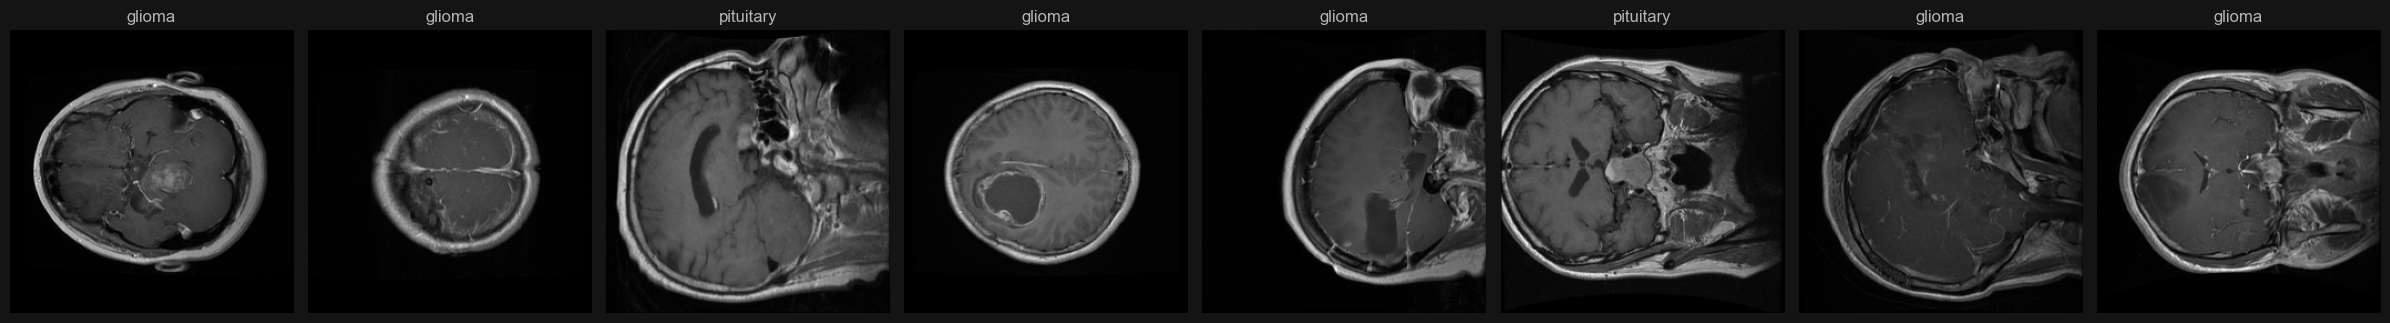

In [20]:
import seaborn as sb

fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(24, 6))
for i, img in enumerate(batch[0][:8]):
    class_name = labels[batch[1][i]]
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(class_name)
    axes[i].set_axis_off()

print(batch[0].shape)
plt.tight_layout()
plt.show()

The process below is called _color quantization_.
<br>
For this task I used Kmeans algorithm to cluster color values in each image.
<br>
So instead of dealing with 255 shades of grey we have only 5 colors per image. 

In [15]:
from sklearn.cluster import KMeans
import cv2 as cv

all_files = lambda label: os.listdir(os.path.join(data_path, label))

_ = 0
for label in labels:
    for i, file in enumerate(all_files(label)):
        
        # if _ >= 10:
        #     break
            
        file_path = os.path.join(data_path, label, file)

        img = cv.imread(file_path, cv.IMREAD_GRAYSCALE)

        width, height = img.shape[0], img.shape[1]

        reshaped_image = np.reshape(img, (width * height, 1))

        kmeans = KMeans(n_clusters=5, random_state=0)
        target = kmeans.fit_predict(reshaped_image)
        color_space = kmeans.cluster_centers_

        img_after = np.reshape(color_space[target], img.shape)
        
        count_black_pixels = np.sum(img_after == img_after.min())
        im_size = img.shape[0] * img.shape[1]
        
        if count_black_pixels >= im_size*0.7:
            # pass
            # print(count_black_pixels, img_after.min())
            cv.imwrite(os.path.join(data_path_after, label, f"{label}_{i}.png"), img_after)
            
            # _ += 1

print('Done!')

KeyboardInterrupt: 

Our dataset contains 512px x 512px images and each pixel has 3 channels so basically each image contains **786 432** values,
<br>
with *color_mode = 'grayscale'* we reduce it to **262 144**. Also keras resized our files to size of 256px x 256px so we end up with **65 536** values per image.

To ensure that there are no leaks that might overfit our model learning process or lead to false accuracy results during testing
<br>
I applied simple iteration that takes image by image from one split and compares it with each image from another split.

In [21]:
# take all images per dataset split into one array for better iteration
train_images = np.concatenate([img.numpy() for img, label in train], axis=0)
val_images = np.concatenate([img.numpy() for img, label in val], axis=0)
test_images = np.concatenate([img.numpy() for img, label in test], axis=0)

count = 0
for train_img in train_images:
    # break
    if any(np.array_equal(train_img, val_img) for val_img in val_images):
        count += 1
print(f"There are {count} data leaks between train and val splits.")

count = 0
for train_img in train_images:
    # break
    if any(np.array_equal(train_img, test_img) for test_img in test_images):
        count += 1
print(f"There are {count} data leaks between train and test splits.")

count = 0
for val_img in val_images:
    # break
    if any(np.array_equal(val_img, test_img) for test_img in test_images):
        count += 1
print(f"There are {count} data leaks between val and test splits.")

There are 0 data leaks between train and val splits.
There are 0 data leaks between train and test splits.
There are 0 data leaks between val and test splits.


#### Step 2 - Class weighting

Class        Count
glioma     : 1426
meningioma : 708
pituitary  : 930


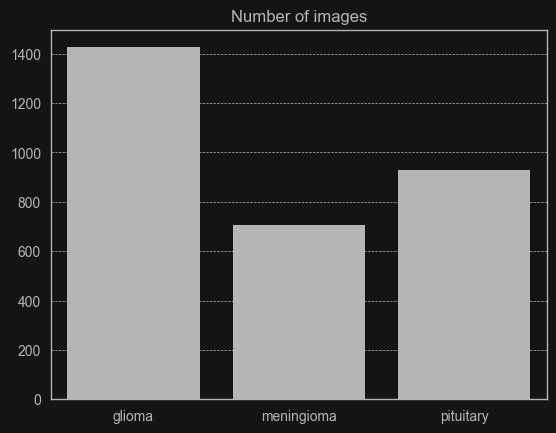

In [22]:
files_per_label = lambda folder: os.listdir(os.path.join(data_path, folder))

# generate dictionary with lengths for each label
labels_len = {label: len(files_per_label(label)) for i, label in enumerate(labels)}

sb.barplot(data=labels_len, x=labels_len.keys(), y=labels_len.values(), color=WHITE_MID, linewidth=0)

print(f"{'Class':<10}   Count")
for label, count in labels_len.items():
    print(f"{label:<10} : {count}")

plt.title('Number of images')
plt.show()

To handle class imbalance, we can downsample dataset or calucalte weights for each class.
<br><br>
**Formula for class weight:**
<br><br>
$w_c = \frac{N}{N_c * C}$
<br><br>
where:
<br>
$ w_c $ = class weight <br>
$ N $ = number of samples in dataset <br>
$ N_c $ = number of samples in class <br>
$ C $ = number of unique classes in dataset

In [23]:
class_weights = dict()

for i, count in enumerate(labels_len.values()):
    class_weights[i] = sum(labels_len.values()) / (len(labels) * count)

print(f"{'Class':<10}   Weight")
for i, weight in class_weights.items():
    print(f"{labels[i]:<10} : {weight}")

Class        Weight
glioma     : 0.7162225338943432
meningioma : 1.4425612052730696
pituitary  : 1.0982078853046595


#### Step 2 - Feature scaling
Usually when we work with Images, the max value is 255 so we're going to transform our values from [min, max] = [0, 255] to [0, 1].

In [24]:
print(batch[0].min(), batch[0].max(), sep='\n')

0.0
253.5


In [25]:
train = train.map(lambda x, y: (x/255, y))
test = test.map(lambda x, y: (x/255, y))
val = val.map(lambda x, y: (x/255, y))

iterator = test.as_numpy_iterator()
batch = iterator.next()

min_value = iterator.next()[0].min()
max_value = iterator.next()[0].max()

print(min_value, max_value, sep='\n')

0.0
0.9862745


#### Checking black/white balance in images.
Every point on the plot is a single image, we can note that most of images hang around ratio of 0.15.

          Mean: 45.710609436035156
 Harmonic mean: 44.06211853027344


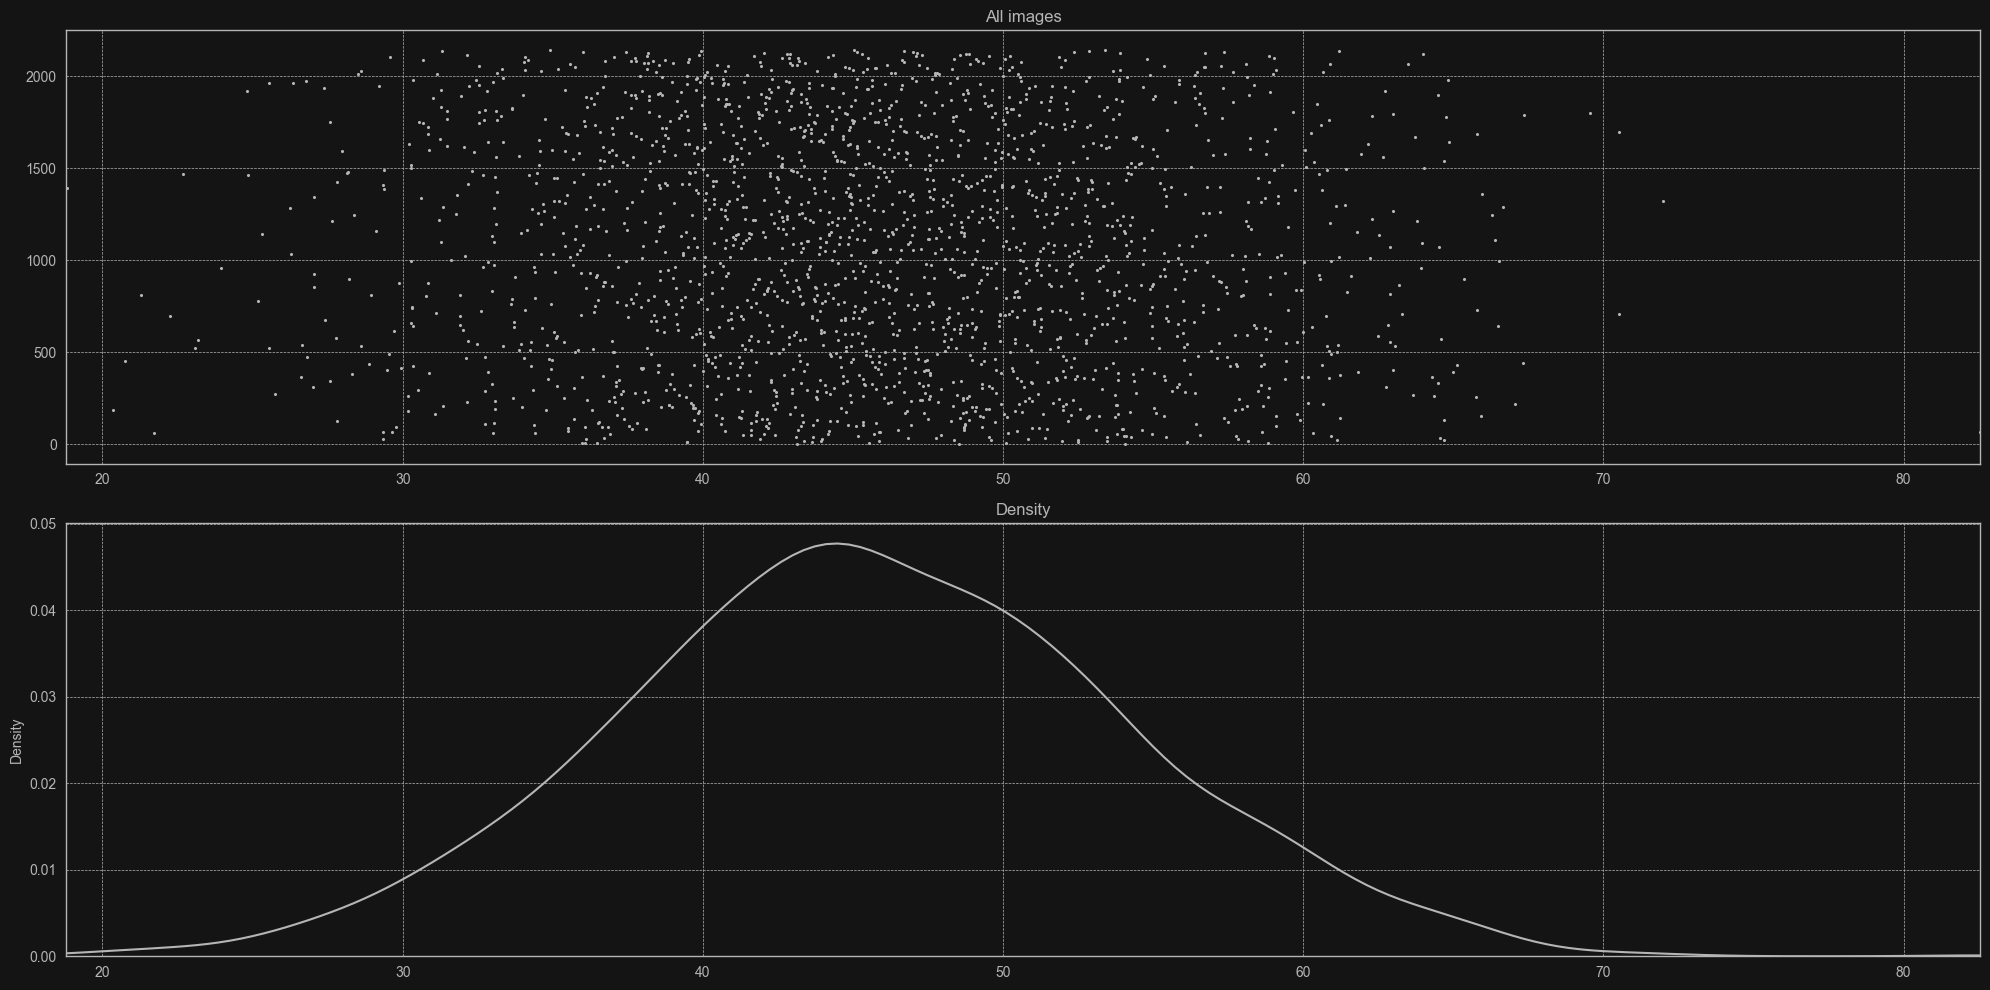

In [26]:
from scipy.stats.mstats import hmean

# skipping value 0 because it's background and it will lower our mean
all_means = [x[x != 0].mean() for x in train_images]

print(f'{'Mean':>14}: {np.mean(all_means)}\n'
      f'{'Harmonic mean':>14}: {hmean(all_means)}')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sb.scatterplot(y=[x for x in range(len(all_means))], x=all_means, color=WHITE_MID, s=20, ax=axes[0], marker='.', linewidth=0)
sb.kdeplot(x=all_means, ax=axes[1], color=WHITE_MID)

padding = (min(all_means) - 0.01, max(all_means) + 0.01)
axes[0].set_xlim(padding)
axes[0].set_title('All images')
axes[1].set_xlim(padding)
axes[1].set_title('Density')
plt.tight_layout()

# II Building Neural Network Model
In short our model base on convolutional layers, where each layer contain filter that convolve with input matrix (image) resulting filtered output.
<br>
As input shape we apply values that corresponds to:
- width = 256
- height = 256
- channel = 1 (grayscale).
<br>

__*ReLU*__ activation function cleans our output from all unnecessary negative values, replacing them with zeros.
<br>
__*Dropout*__ layers drops random neurons each time convolution layer is being applied, reducing chance to overfit.
<br>
Since our dataset contain 3 classes I applied __*softmax*__ activation to the last step.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, ReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD

In [28]:
def create_model(num_filters=16, kernel_size=3, learning_rate=0, regulate=0, slope=0):
    
    model = Sequential()
    
    model.add(Input(shape=(256, 256, 1)))
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(num_filters, (kernel_size, kernel_size), 1, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPooling2D())
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    
    return model

In [29]:
model = create_model(learning_rate=0.0001, slope=0)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 254, 254, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 125, 125, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,692,227 (14.08 MB)

 Trainable params: 3,692,227 (14.08 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
n_epochs = 20
hist = model.fit(train, validation_data=val, epochs=n_epochs, class_weight=class_weights, verbose=2)

Epoch 1/20
268/268 - 25s - 92ms/step - loss: 0.7472 - sparse_categorical_accuracy: 0.6343 - val_loss: 0.7366 - val_sparse_categorical_accuracy: 0.7108
Epoch 2/20
268/268 - 23s - 84ms/step - loss: 0.5588 - sparse_categorical_accuracy: 0.7402 - val_loss: 0.6041 - val_sparse_categorical_accuracy: 0.7141
Epoch 3/20
268/268 - 22s - 83ms/step - loss: 0.4545 - sparse_categorical_accuracy: 0.8055 - val_loss: 0.5020 - val_sparse_categorical_accuracy: 0.8399
Epoch 4/20
268/268 - 22s - 83ms/step - loss: 0.3821 - sparse_categorical_accuracy: 0.8428 - val_loss: 0.4775 - val_sparse_categorical_accuracy: 0.8513
Epoch 5/20
268/268 - 22s - 81ms/step - loss: 0.3214 - sparse_categorical_accuracy: 0.8671 - val_loss: 0.4322 - val_sparse_categorical_accuracy: 0.8676
Epoch 6/20
268/268 - 22s - 84ms/step - loss: 0.2806 - sparse_categorical_accuracy: 0.8829 - val_loss: 0.4909 - val_sparse_categorical_accuracy: 0.7549
Epoch 7/20
268/268 - 22s - 83ms/step - loss: 0.2340 - sparse_categorical_accuracy: 0.9104 - va

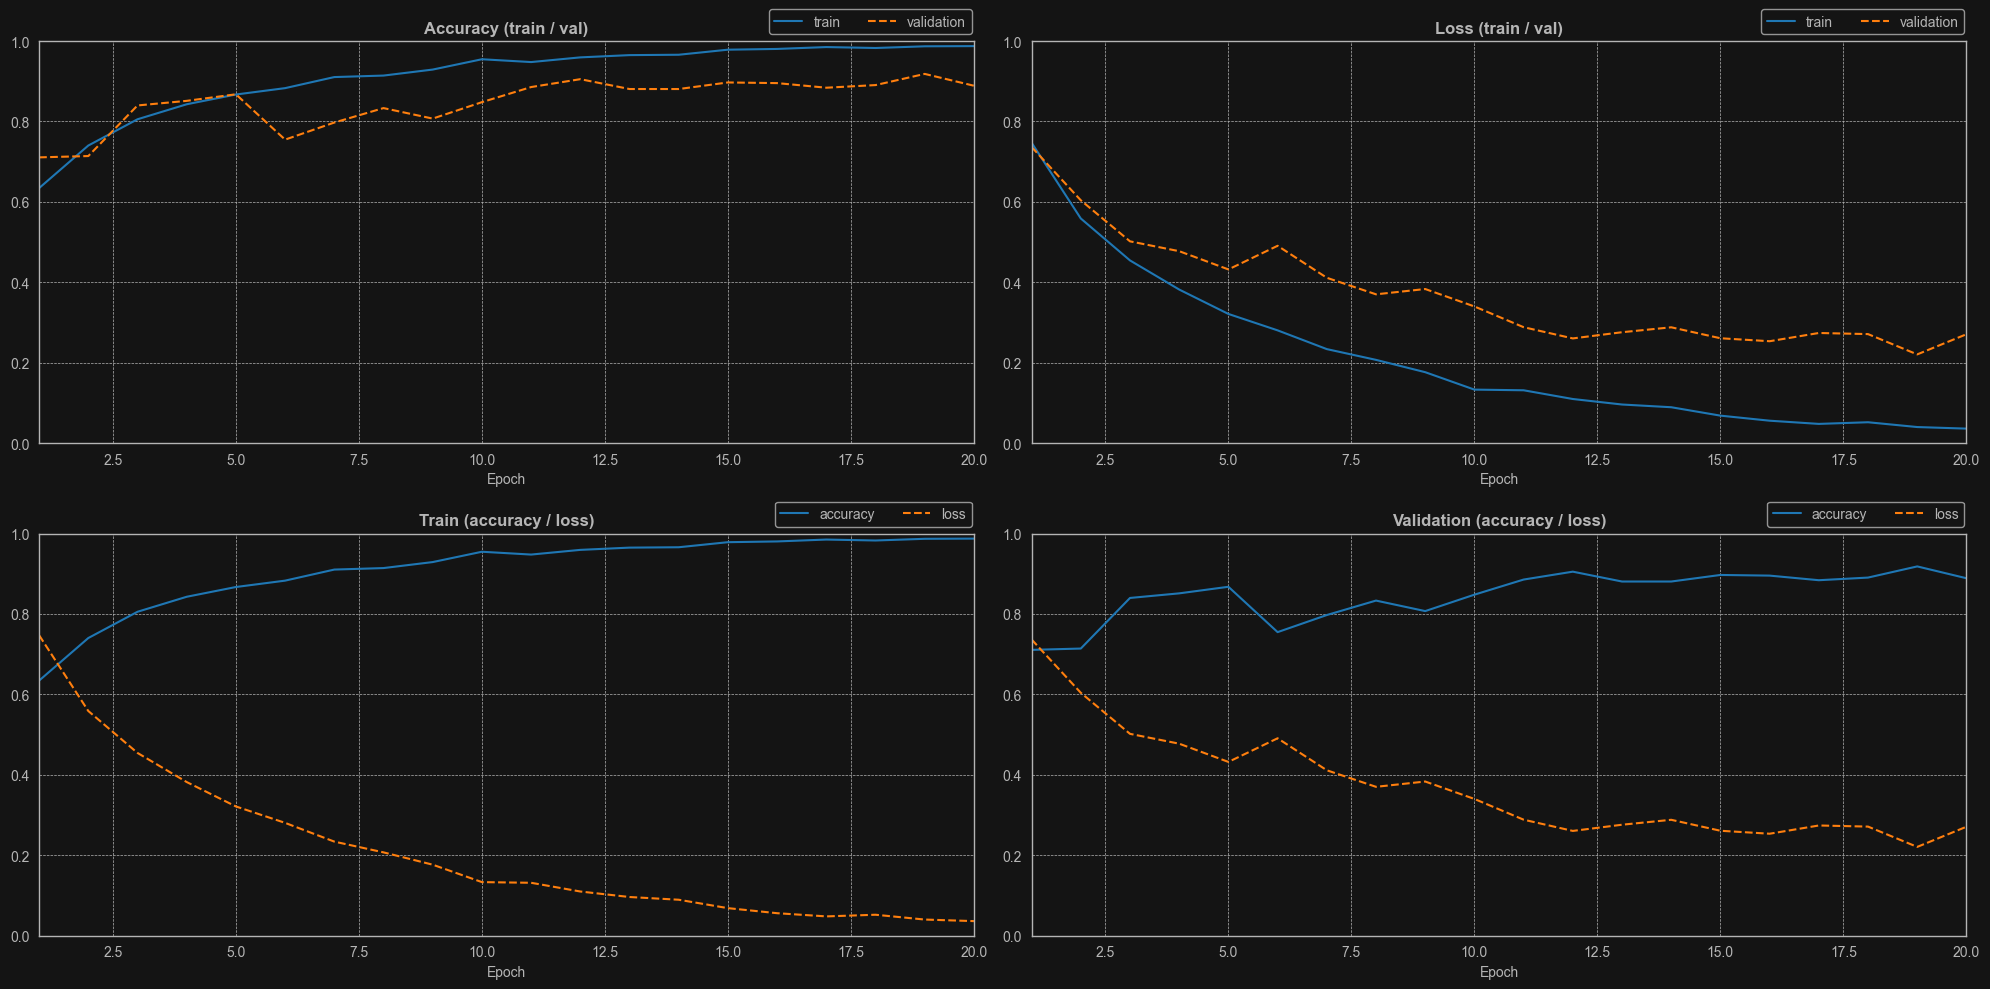

In [31]:
acc_labels = list(hist.history.keys())

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
axes = axes.flatten()

sb.lineplot(data=hist.history, y='sparse_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='train', ax=axes[0])
sb.lineplot(data=hist.history, y='val_sparse_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='validation', ax=axes[0], linestyle='--')

sb.lineplot(data=hist.history, y='loss', x=[x for x in range(1, n_epochs+1, 1)], label='train', ax=axes[1])
sb.lineplot(data=hist.history, y='val_loss', x=[x for x in range(1, n_epochs+1, 1)], label='validation', ax=axes[1], linestyle='--')

sb.lineplot(data=hist.history, y='sparse_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='accuracy', ax=axes[2])
sb.lineplot(data=hist.history, y='loss', x=[x for x in range(1, n_epochs+1, 1)], label='loss', ax=axes[2], linestyle='--')

sb.lineplot(data=hist.history, y='val_sparse_categorical_accuracy', x=[x for x in range(1, n_epochs+1, 1)], label='accuracy', ax=axes[3])
sb.lineplot(data=hist.history, y='val_loss', x=[x for x in range(1, n_epochs+1, 1)], label='loss', ax=axes[3], linestyle='--')

for i in range(4):
    axes[i].legend(loc='lower right', bbox_to_anchor=(1.005, 1), ncol=2)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylim([0, 1])
    axes[i].set_xlim([1, n_epochs])
    axes[i].set_ylabel('')

axes[0].set_title('Accuracy (train / val)', weight='bold')
axes[1].set_title('Loss (train / val)', weight='bold')
axes[2].set_title('Train (accuracy / loss)', weight='bold')
axes[3].set_title('Validation (accuracy / loss)', weight='bold')

plt.tight_layout()

Both Training and Validation curves looks very promising, however we have to test our model for final results.

In [32]:
y_true = []
y_pred = []

for batch_images, batch_labels in test:
    y_true_batch = batch_labels
    y_pred_batch = np.argmax(model.predict(batch_images, verbose=0), axis=1)

    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

              precision    recall  f1-score   support

      glioma       0.88      0.99      0.93       143
  meningioma       0.93      0.71      0.80        72
   pituitary       0.96      0.95      0.95        93

    accuracy                           0.91       308
   macro avg       0.92      0.88      0.89       308
weighted avg       0.91      0.91      0.91       308



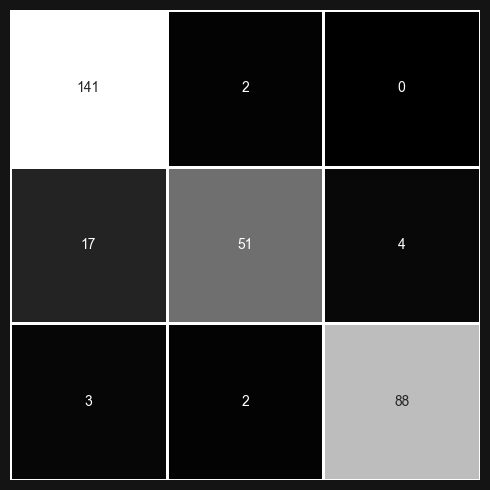

In [33]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(y_true, y_pred, target_names=labels)
print(report)

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
fig = plt.figure(figsize=(5, 5))
fig = sb.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greys_r', linewidths=2)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.axis('off')
plt.tight_layout()

# III Conclusion
We ended up with decent F1 score of 91%. Despite this fact, model still have some disproportion with accuracy if we look at _meningioma_ class, propably because of it's size.
<br>
Note that the dataset itself is very good quality, it's balanced in terms of specific factors like: resolution, color range, object placement.<br>
The model performs very well also on unprocessed images which shows it's versatility.
<br><br>
#### Significant improvement noticed after:
- Tweaking learning rate of the Adam optimizer
- Weighting classes
- Adding dropout layers for each convolution layer
<br>
instead of holding one dropout layer before output densing layers.
<br><br>

#### I hope you enjoyed reading this project :] <br>
_Gracjan Pawłowski, 2024_